# NSRR testing set validation

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sns.set(style="ticks", font_scale=1.1)

# Define paths
wdir = "output/cv/"
wdir_demo = "output/demo/"
outdir = "output/plots/"

In [2]:
# Choose model
model = "eeg+eog+emg+demo"

feat_files = glob.glob(wdir + "%s/cv_loo_nsrr_*.parquet" % model)

df = []
for f in feat_files:
    df.append(pd.read_parquet(f))
    
df = pd.concat(df)
df['subj'] = df['subj'].astype(str)
df['dataset'] = df['dataset'].str.upper()
print(df['subj'].nunique(), 'subjects')
print(df.shape)
df.head().round(2)

557 subjects
(556228, 13)


,subj,model,age,male,y_true,y_pred,confidence,proba_N1,proba_N2,proba_N3,proba_R,proba_W,dataset
0,300002,eeg+eog+emg+demo,9.0,0,W,W,0.99,0.00,0.00,0.0,0.0,0.99,CHAT
1,300002,eeg+eog+emg+demo,9.0,0,W,W,0.99,0.01,0.01,0.0,0.0,0.99,CHAT
2,300002,eeg+eog+emg+demo,9.0,0,W,W,0.95,0.03,0.02,0.0,0.0,0.95,CHAT
3,300002,eeg+eog+emg+demo,9.0,0,W,W,0.97,0.03,0.01,0.0,0.0,0.97,CHAT
4,300002,eeg+eog+emg+demo,9.0,0,W,W,0.98,0.02,0.00,0.0,0.0,0.98,CHAT


In [3]:
# To avoid invalid F1, we remove subjects that do not have all sleep stages in original scoring
n_stage_per_subj = df.groupby('subj')['y_true'].nunique()
bad_ss = n_stage_per_subj[n_stage_per_subj != 5].index
df = df[~df['subj'].isin(bad_ss)].reset_index(drop=True)
print(df['subj'].nunique(), 'remaining subjects')
print(df.shape)

542 remaining subjects
(541371, 13)


## Demographics

In [4]:
# First, let's merge with the main demographics
df_demo = pd.read_csv(wdir_demo + "demo_nsrr_all.csv")
df_demo.drop(columns=['male', 'age'], inplace=True)
df_demo.head()

,dataset,subj,bmi,ahi,ethnicity,set
0,CCSHS,1800001,19.089716,0.244898,caucasian,training
1,CCSHS,1800005,29.338584,0.239521,caucasian,testing
2,CCSHS,1800007,35.897564,1.846154,african,training
3,CCSHS,1800013,21.176986,0.113636,caucasian,training
4,CCSHS,1800014,33.587853,1.901408,african,training


In [5]:
grp_subj = df.groupby('subj', as_index=False).first()
# Left merge to keep only testing set
grp_subj = grp_subj.merge(df_demo, how="left")
grp_subj.sort_values(by=['dataset', 'subj'], inplace=True)
grp_subj

,subj,model,age,male,y_true,y_pred,confidence,proba_N1,proba_N2,proba_N3,proba_R,proba_W,dataset,bmi,ahi,ethnicity,set
25,1800005,eeg+eog+emg+demo,17.28,1,W,W,0.999966,0.000007,0.000025,2.320226e-06,2.746707e-07,0.999966,CCSHS,29.338584,0.239521,caucasian,testing
26,1800031,eeg+eog+emg+demo,18.25,1,W,W,0.997505,0.001451,0.000969,5.519884e-05,2.062744e-05,0.997505,CCSHS,25.180211,3.742204,caucasian,testing
27,1800042,eeg+eog+emg+demo,17.45,1,W,W,0.998799,0.000736,0.000451,4.167879e-06,9.983258e-06,0.998799,CCSHS,21.604843,0.284360,caucasian,testing
28,1800044,eeg+eog+emg+demo,17.24,0,W,W,0.995918,0.000184,0.002425,1.464138e-03,8.955249e-06,0.995918,CCSHS,24.724990,0.841121,caucasian,testing
29,1800067,eeg+eog+emg+demo,17.91,0,W,W,0.999877,0.000006,0.000037,7.928949e-05,6.948177e-08,0.999877,CCSHS,19.698369,0.545455,caucasian,testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,205412,eeg+eog+emg+demo,59.00,1,W,W,0.999561,0.000270,0.000160,6.599766e-06,1.749023e-06,0.999561,SHHS,29.627703,24.805369,caucasian,testing
218,205605,eeg+eog+emg+demo,67.00,0,W,W,0.999756,0.000054,0.000150,3.881015e-05,1.556900e-06,0.999756,SHHS,30.415652,2.592122,caucasian,testing
219,205648,eeg+eog+emg+demo,70.00,1,W,W,0.999992,0.000003,0.000005,4.514464e-07,1.419482e-08,0.999992,SHHS,27.129630,7.340824,caucasian,testing
220,205672,eeg+eog+emg+demo,66.00,1,W,W,0.999277,0.000041,0.000606,7.569181e-05,4.875574e-07,0.999277,SHHS,33.756110,63.267327,caucasian,testing


### Descriptive statistics

In [6]:
df.shape[0] / 120

4511.425

In [7]:
grp_subj['male'].value_counts(normalize=True)

1    0.562731
0    0.437269
Name: male, dtype: float64

In [8]:
grp_subj['dataset'].value_counts(sort=False)

CCSHS     95
MROS      91
CHAT      77
SHHS     100
MESA      93
CFS       86
Name: dataset, dtype: int64

46.37 ± 27.87 (min = 5.00, median = 54.3620807665, max = 94.00)


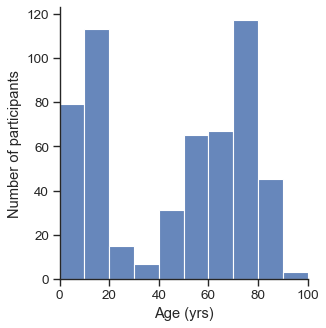

In [9]:
# Age distribution
def mean_std(x):
    print(f"{x.mean():.2f} ± {x.std():.2f} (min = {x.min():.2f}, median = {x.median()}, max = {x.max():.2f})")

grp_subj['age'].agg(mean_std)

fig, ax = plt.subplots(1, 1, figsize=(4, 4.5), dpi=80)
sns.histplot(grp_subj['age'], bins=np.linspace(0, 100, 11), stat='count', alpha=0.85)
plt.xlabel("Age (yrs)")
plt.xlim(0, 100)
plt.ylabel("Number of participants")
# plt.title("Age distribution of the testing set");
sns.despine()
plt.savefig(outdir + "cv_hist_age.png", dpi=300, bbox_inches="tight")

In [10]:
grp_subj['ahi'].agg(mean_std)

12.01 ± 15.49 (min = 0.00, median = 6.0, max = 102.30)


In [11]:
grp_subj['bmi'].agg(mean_std)

26.25 ± 7.06 (min = 13.20, median = 25.657715371, max = 54.32)


In [12]:
100 * grp_subj['ethnicity'].value_counts(normalize=True).round(3)

caucasian    60.1
african      28.2
hispanic      6.1
other         5.5
Name: ethnicity, dtype: float64

In [26]:
grp_subj.groupby('dataset')['age'].agg(['mean', 'std', 'min', 'max']).round(2)

,mean,std,min,max
dataset,,,,
CCSHS,17.76,0.39,17.02,18.94
CFS,36.58,17.62,7.29,78.60
CHAT,6.49,1.51,5.00,10.00
MESA,69.85,9.52,54.00,94.00
MROS,76.31,5.49,68.00,90.00
SHHS,63.57,10.86,40.00,87.00


## Performance

In [ ]:
# Overall (not reported in the paper)
print("Acc.:\t  %.3f" % skm.accuracy_score(df['y_true'], df['y_pred']))
print("Kappa:\t  %.3f" % skm.cohen_kappa_score(df['y_true'], df['y_pred']))
print("MCC:\t  %.3f" % skm.matthews_corrcoef(df['y_true'], df['y_pred']))
print("F1-macro: %.3f" % skm.f1_score(df['y_true'], df['y_pred'], average='macro'))
print("F1-micro: %.3f" % skm.f1_score(df['y_true'], df['y_pred'], average='micro'))

In [ ]:
# Per each night
df_scores = []

labels = ['N1', 'N2', 'N3', 'R', 'W']

def perc_transition(col):
    return (col != col.shift(1)).sum() / col.shape[0]

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']
    n = yt.shape[0]

    sub_scores = {
        'dataset': df_sub['dataset'].iloc[0],
        'age': df_sub['age'].iloc[0],
        'male': df_sub['male'].iloc[0],
        'dur_min': yt.size / 2,
        # % Transitions
        'perc_trans_true': perc_transition(yt),
        'perc_trans_pred': perc_transition(yp),
        # Accuracy
        'accuracy': skm.accuracy_score(yt, yp),
        'kappa': skm.cohen_kappa_score(yt, yp),
        'MCC': skm.matthews_corrcoef(yt, yp),
        'f1_macro': skm.f1_score(yt, yp, average='macro'),
    }

    # F1 for each stage
    f1 = skm.f1_score(yt, yp, average=None, labels=labels)
    for f, l in zip(f1, labels):
        sub_scores['f1_' + l] = f

    # Proportion of each stage (NaN = 0)
    prop_true = (yt.value_counts() / n).add_prefix('perc_').add_suffix('_true')
    prop_pred = (yp.value_counts() / n).add_prefix('perc_').add_suffix('_pred')
    sub_scores.update(prop_true.to_dict())
    sub_scores.update(prop_pred.to_dict())

    # Append to main dataframe
    df_scores.append(pd.DataFrame(sub_scores, index=[sub]))

df_scores = pd.concat(df_scores)
df_scores.sort_index(axis=1, inplace=True)
df_scores.index.name = 'subj'
df_scores.round(3)

In [ ]:
# Fill the NaN in perc_XX by zero
# df_scores.isna().sum(0)
df_scores['perc_N3_pred'].fillna(0, inplace=True)

In [ ]:
# Save to Excel for visual inspection
df_scores.round(3).set_index('dataset', append=True).to_excel(wdir + model + "/df_scores.xlsx", freeze_panes=(1, 2))

In [ ]:
# Contribution of stage-specific F1 to accuracy, kappa and F1-macro
df_scores.iloc[:, [1, 5, 6, 7, 8, 9, 10, 11]].corr().round(2)

In [ ]:
# Show the median
df_scores.median().round(3)

In [ ]:
# Show the median per dataset
df_scores.groupby('dataset').median().T.round(3)

### Define colors

In [ ]:
cmap = list(sns.color_palette("Blues", n_colors=10, as_cmap=False, desat=1))
color_pred = cmap[-1]
color_ref = "tab:orange"
cmap_stages = ['#99d7f1', '#009DDC', 'xkcd:twilight blue', 'xkcd:rich purple', 'xkcd:sunflower']

### Boxplots

#### Accuracy, MCC and F1-macro

In [ ]:
# Boxplot of accuracy
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
order = df_scores.groupby("dataset")['accuracy'].median().sort_values(ascending=False).index

ax1 = sns.boxplot(data=df_scores, y='accuracy', x='dataset', color=color_pred, saturation=1,
                  order=order, fliersize=0, width=0.6, notch=True, linewidth=1.5)
                  # boxprops=dict(edgecolor="k"))

# plt.title("Performance on testing set (n=%i)" % df_scores.shape[0])
plt.xlabel("Dataset (~100 test nights each)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)

# plt.axhline(0.8, ls=":", color="tab:grey")

ax.annotate("Accuracy (median): %.2f\nKappa (median): %.2f" % 
            (df_scores['accuracy'].median(), df_scores['kappa'].median()),
            xy=(5, 0.55), ha="right", fontstyle="italic", fontweight="semibold")

sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_boxplot_accuracy_datasets.png", dpi=300, bbox_inches="tight")

#### Distribution of F1-score per stage

For N3, one issue is that we have a lot of participants with only a few epochs of N3 sleep across the night. If the algorithm misses some or all of these epochs, the resulting F1-score can be very low, or even zero.

One solution is to set the F1-scores values to NaN whenever less than 5 min of the specified stage is present in the ground-truth scoring.

In [ ]:
df_f1 = df_scores[['f1_N1', 'f1_N2', 'f1_N3', 'f1_R', 'f1_W']].copy()
df_f1.columns = df_f1.columns.str.split('_').str.get(1)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
sns.boxplot(data=df_f1, palette=cmap_stages, fliersize=0, ax=ax, saturation=1, notch=True)
plt.xlabel("Stage")
plt.ylabel("F1-score")
sns.despine()

### Stage discrepancies

In [ ]:
# Effect size of the percentage of transitions
def mean_std(x):
    x = x * 100
    return f"{x.mean().round(1)} ± {x.std(). round(1)}"

display(df_scores[['perc_trans_pred', 'perc_trans_true']].agg(mean_std))
pg.ttest(df_scores['perc_trans_pred'], df_scores['perc_trans_true'], paired=True).round(2)

In [ ]:
df_prop_pred = df_scores.filter(like="_pred").iloc[:, :-1].melt(var_name="Stage", value_name="Proportion", ignore_index=False)
df_prop_true = df_scores.filter(like="_true").iloc[:, :-1].melt(var_name="Stage", value_name="Proportion", ignore_index=False)

df_prop_pred['Stage'] = df_prop_pred['Stage'].str.split('_').str.get(1)
df_prop_true['Stage'] = df_prop_true['Stage'].str.split('_').str.get(1)

df_prop_pred['Scoring'] = 'Predicted'
df_prop_true['Scoring'] = 'Reference'

df_prop = pd.concat((df_prop_pred.reset_index(), df_prop_true.reset_index()))
df_prop = df_prop.sort_values(by=['subj', 'Stage', 'Scoring']).reset_index(drop=True)

df_prop

In [ ]:
# Calculate the effect size
ptest = df_prop.pairwise_ttests(dv="Proportion", within=['Stage', "Scoring"], subject="subj", effsize="cohen").iloc[11:, :].round(3)
ef = ptest.loc[:, ['Stage', 'cohen']].set_index("Stage").abs()
display(ef)

# Boxplot
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)

sns.boxplot(y=df_prop['Proportion'] * 100, x=df_prop['Stage'], hue=df_prop['Scoring'],
            hue_order=['Reference', 'Predicted'], 
            palette=[color_ref, color_pred], 
            saturation=1, width=0.6, fliersize=0, linewidth=1.5, notch=True)

plt.ylim(0, 80)
plt.yticks([0, 20, 40, 60, 80])
plt.legend(frameon=False, loc="upper right")
plt.ylabel("Proportion of time in bed (%)");

sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_stage_proportion.png", dpi=300, bbox_inches="tight")

### Bland-Altman plots

See https://sri-human-sleep.github.io/sleep-trackers-performance/AnalyticalPipeline_v1.0.0.html#24_bland-altman_plots

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), dpi=80, sharex=False, sharey=True)

ax = ax.flatten()

for i, l in enumerate(labels[:-1]):
    ax_i = pg.plot_blandaltman(
        x=df_scores['perc_%s_pred' % l] * 100, 
        y=df_scores['perc_%s_true' % l] * 100,
        xaxis="y",
        annotate=False,
        scatter_kws={'color': color_pred, 'alpha': 0.3, 's': 20},
        confidence=None, ax=ax[i])
    if l == 'R':
        l = "REM"
    ax_i.set_title("%s sleep" % l)
    ax_i.set_xlabel("Reference %TIB")
    ax_i.set_ylabel("")
    
plt.subplots_adjust(wspace=0.2)

ax[0].set_ylabel("Predicted - reference\n%TIB")
sns.despine()

plt.savefig(outdir + "cv_baplots.png", dpi=300, bbox_inches="tight")

In [ ]:
# Export for further analyses in R
df[['subj', 'y_true', 'y_pred']].to_csv("BAplots/predictions.csv", index=False)

#### Confusion matrices

The normalized confusion matrices show the sensitivity (= recall).

In [ ]:
cm = 100 * skm.confusion_matrix(df['y_true'], df['y_pred'], labels=labels, normalize="true")
cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(4.5, 4.5))
sns.heatmap(cm, annot=True, vmin=0, vmax=100, cmap="Blues", square=True, cbar=False, fmt=".1f")
plt.ylabel("Reference")
plt.xlabel("Predicted")
# plt.title("Recall", y=1.02, fontweight="bold")
plt.tight_layout()
# plt.savefig(outdir + "cv_confusion_recall.png", dpi=300, bbox_inches="tight")

In [ ]:
# Precision 
# skm.precision_recall_fscore_support(df['y_true'], df['y_pred'], labels=labels)
cm = 100 * skm.confusion_matrix(df['y_true'], df['y_pred'], labels=labels, normalize="pred")
cm = pd.DataFrame(cm, index=labels, columns=labels).round(1)

# Plot
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(4.5, 4.5))
sns.heatmap(cm, annot=True, vmin=0, vmax=100, cmap="Blues", square=True, cbar=False, fmt=".1f")
plt.ylabel("Reference")
plt.xlabel("Predicted")
# plt.title("Precision", y=1.02, fontweight="bold")
plt.tight_layout()
plt.savefig(outdir + "cv_confusion_prec.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(2, 3, dpi=90, figsize=(13, 9), sharex=False, sharey=False)

ax = ax.flatten()

for i, dset in enumerate(tqdm(df['dataset'].unique(), leave=False)):
    df_dset = df[df['dataset'] == dset]
    cm = 100 * skm.confusion_matrix(df_dset['y_true'], df_dset['y_pred'], labels=labels, normalize="true")
    cm = pd.DataFrame(cm, index=labels, columns=labels).round(1)

    # Plot
    sns.heatmap(cm, annot=True, vmin=0, vmax=100, cmap="Blues", square=False, cbar=False, ax=ax[i])
    ax[i].set_title("%s" % dset, fontweight="bold", y=1.02)
    ax[i].set_ylabel("Reference")
    ax[i].set_xlabel("Predicted")

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig(outdir + "cv_confusion_datasets.png", dpi=300, bbox_inches="tight")

*************

## Moderator analyses

In [ ]:
# First we define a color palette that we'll use in each individual plot
# cmap = list(sns.color_palette("magma_r", n_colors=8, desat=1))
# sns.color_palette("magma_r", n_colors=8, desat=1)

# From: https://carto.com/carto-colors/
# cmap = ['#E58606', '#5D69B1', '#CC61B0', '#24796C', 
#         '#DAA51B', '#2F8AC4', '#764E9F', '#ED645A', '#CC3A8E', '#A5AA99']

### Accuracy as a function of age / sex

In [ ]:
df_scores['Sex'] = df_scores['male'].map({0: "Female", 1: "Male"})

display(df_scores['Sex'].value_counts())

# T-test
display(df_scores.pairwise_ttests(dv="accuracy", between="Sex").round(3))

# Plot
sns.set(style="ticks", font_scale=1.1)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5), dpi=100)

sns.boxplot(data=df_scores, x="Sex", y="accuracy", width=0.7, fliersize=0,
            saturation=1, color=color_pred, ax=ax)

# sns.barplot(data=df_scores, x="Sex", y="accuracy", ci="sd", capsize=.1, errwidth=1, saturation=1, color=cmap[1], ax=ax)

# Add "n=" on top
for i, ac in enumerate(["Female", "Male"]):
    n = df_scores['Sex'].value_counts()[ac]
    plt.annotate("n=%i" % n, (i, 0.96), ha="center", fontsize=11, fontstyle="italic")

plt.ylim(0.5, 1)
plt.ylabel("Accuracy")
plt.xlabel("Sex")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_male.png", dpi=300, bbox_inches="tight")

In [ ]:
# Test for raw bivariate correlations between age and accuracy / F1-macro
corr_age = df_scores.pairwise_corr([['age'], ['accuracy', 'MCC', 'f1_macro']]).round(3)
display(corr_age)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)
sns.regplot(data=df_scores, x="age", y="accuracy", truncate=True, order=1,
            scatter_kws={"s": 20, "alpha": .2, "lw": 1},
            line_kws={"color": "k", "lw": 3}, 
            color=color_pred, ax=ax)
plt.ylim(0.5, 1)
plt.xlim(0, 100)
plt.xlabel("Age")
plt.ylabel("Accuracy")

plt.annotate("r=%.2f" % corr_age.loc[0, 'r'], (0.6, 0.1), xycoords="axes fraction", fontstyle="italic")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_agecorr.png", dpi=300, bbox_inches="tight")

In [ ]:
# Create age categories
df_scores['age_cut'] = pd.cut(
    df_scores['age'], [0, 10, 20, 60, 75, 100],
    labels=['<10', '10-20', '20-60', '60-75', '≥75'],
    right=False, include_lowest=True)
display(df_scores['age_cut'].value_counts(sort=False))

In [ ]:
# ANOVA
display(df_scores.anova(dv="accuracy", between="age_cut").round(3))
display(df_scores.pairwise_tukey(dv="accuracy", between="age_cut").round(3))

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=100)

sns.boxplot(data=df_scores, x="age_cut", y="accuracy", width=0.7, fliersize=0,
            saturation=1, color=color_pred, ax=ax)

# Add "n=" on top
for i, ac in enumerate(df_scores['age_cut'].cat.categories):
    n = df_scores['age_cut'].value_counts()[ac]
    # yloc = df_scores.groupby(['age_cut'])['accuracy'].quantile(0.99)[ac] + 0.03
    plt.annotate("n=%i" % n, (i, 0.96), ha="center", fontsize=11, fontstyle="italic")

plt.ylim(0.5, 1)
plt.ylabel("Accuracy")
plt.xlabel("Age")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_age.png", dpi=300, bbox_inches="tight")

### Accuracy as a function of BMI / AHI / Ethnicity

In [ ]:
# First, we need to merge the demographics
if 'bmi' not in df_scores.columns:
    df_scores = df_scores.join(df_demo.set_index(['subj']).drop(columns=['dataset']), how="left")
    df_scores.round(1)

In [ ]:
# Correlation with BMI
corr_bmi = df_scores.pairwise_corr([['bmi'], ['accuracy', 'MCC', 'f1_macro']]).round(3)
display(corr_bmi)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)
sns.regplot(data=df_scores, x="bmi", y="accuracy", truncate=True,
            scatter_kws={"s": 20, "alpha": .2, "lw": 1},
            line_kws={"color": "k", "lw": 3}, 
            color=color_pred, ax=ax)
plt.ylim(0.5, 1)
plt.xlim(10, 60)
plt.xlabel("BMI")
plt.ylabel("Accuracy")

plt.annotate("r=%.2f" % corr_bmi.loc[0, 'r'], (0.6, 0.1), xycoords="axes fraction", fontstyle="italic")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_bmi.png", dpi=300, bbox_inches="tight")

In [ ]:
# Correlation with AHI - same result when adjusting for age!
corr_ahi = df_scores.pairwise_corr([['ahi'], ['accuracy', 'MCC', 'f1_macro']]).round(3)  # covar=['age']
display(corr_ahi)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)
sns.regplot(data=df_scores, x="ahi", y="accuracy", truncate=True,
            scatter_kws={"s": 20, "alpha": .2, "lw": 1},
            line_kws={"color": "k", "lw": 3}, 
            color=color_pred, ax=ax)
plt.ylim(0.5, 1)
plt.xlim(0, 110)
plt.xlabel("AHI")
plt.ylabel("Accuracy")

plt.annotate("r=%.2f" % corr_ahi.loc[0, 'r'], (0.6, 0.1), xycoords="axes fraction", fontstyle="italic")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_ahi.png", dpi=300, bbox_inches="tight")

In [ ]:
# Does AHI correlates with the number of stage transitions?
df_scores.pairwise_corr(['perc_trans_true', 'ahi']).round(3)

In [ ]:
# Ethnicity - no sig difference
display(df_scores.anova(dv="accuracy", between="ethnicity").round(3))
# display(df_scores.pairwise_tukey(dv="accuracy", between="ethnicity").round(3))

df_scores['Race/Ethnicity'] = df_scores['ethnicity'].replace({
    'caucasian': "White",
    'african': "Black",
    'hispanic': "Hispanic",
    'other': "Other",
})

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)
sns.boxplot(data=df_scores, x="Race/Ethnicity", y="accuracy", width=0.7, fliersize=0,
            saturation=1, color=color_pred, ax=ax)
plt.ylim(0.5, 1)

# Add "n=" on top
for i, ac in enumerate(df_scores['Race/Ethnicity'].unique()):
    n = df_scores['Race/Ethnicity'].value_counts(dropna=False)[ac]
    # yloc = df_scores.groupby(['age_cut'])['accuracy'].quantile(0.99)[ac] + 0.03
    plt.annotate("n=%i" % n, (i, 0.96), ha="center", fontsize=11, fontstyle="italic")

plt.ylabel("Accuracy")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_ethnicity.png", dpi=300, bbox_inches="tight")

### Stage transitions

Are most of the errors located around transitions between stages?

Here, we use PSG to define the transitions between stages.

In [ ]:
df_trans = []

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']

    # Identify stable periods, i.e. the 3 epochs before / after are similar (3 minutes window)
    first_ep, last_ep = yt.iloc[0], yt.iloc[-1]
    stable = np.logical_and.reduce((
        yt.shift(1, fill_value=first_ep) == yt,  # = same as previous one
        yt.shift(-1, fill_value=last_ep) == yt, # = same as next one
        yt.shift(2, fill_value=first_ep) == yt,
        yt.shift(-2, fill_value=last_ep) == yt,
        yt.shift(3, fill_value=first_ep) == yt,
        yt.shift(-3, fill_value=last_ep) == yt,
    ))

    # Append to main dict
    sub_scores = {
        'dataset': df_sub['dataset'].iloc[0],
        'age': df_sub['age'].iloc[0],
        'male': df_sub['male'].iloc[0],
        'n_stable': len(stable[stable]),
        'n_trans': len(stable[~stable]),
        'acc_stable': skm.accuracy_score(yt[stable], yp[stable]),
        'acc_trans': skm.accuracy_score(yt[~stable], yp[~stable]),
        'mcc_stable': skm.matthews_corrcoef(yt[stable], yp[stable]),
        'mcc_trans': skm.matthews_corrcoef(yt[~stable], yp[~stable])
    }

    # Append to main dataframe
    df_trans.append(pd.DataFrame(sub_scores, index=[sub]))

df_trans = pd.concat(df_trans)
df_trans.sort_index(axis=1, inplace=True)
df_trans.index.name = 'subj'
df_trans.round(3)

In [ ]:
# Average and T-test
display(df_trans[['acc_stable', 'acc_trans']].apply(mean_std))

pg.ttest(df_trans['acc_stable'], df_trans['acc_trans'], paired=False)
# pg.ttest(df_trans['mcc_stable'], df_trans['mcc_trans'], paired=False)

In [ ]:
# Plot
sns.set(style="ticks", font_scale=1.1)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5), dpi=100)
sns.boxplot(data=df_trans[['acc_stable', 'acc_trans']], width=0.7, fliersize=0,
            saturation=1, color=color_pred, ax=ax)

# sns.barplot(data=df_trans[['acc_stable', 'acc_trans']], ci="sd", capsize=.1, errwidth=1, saturation=1, color=cmap[6], ax=ax)

plt.ylim(0.5, 1.01)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.xticks([0, 1], ['Stable', 'Transition'])
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_accuracy_transitions.png", dpi=300, bbox_inches="tight")

### High vs low confidence

In [ ]:
df_conf = []

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']
    
    highconf = df_sub['confidence'] >= 0.8

    # Append to main dict
    sub_scores = {
        'dataset': df_sub['dataset'].iloc[0],
        'age': df_sub['age'].iloc[0],
        'male': df_sub['male'].iloc[0],
        'n_highconf': len(highconf[highconf]),
        'n_lowconf': len(highconf[~highconf]),
        'acc_highconf': skm.accuracy_score(yt[highconf], yp[highconf]),
        'acc_lowconf': skm.accuracy_score(yt[~highconf], yp[~highconf]),
        'mcc_highconf': skm.matthews_corrcoef(yt[highconf], yp[highconf]),
        'mcc_lowconf': skm.matthews_corrcoef(yt[~highconf], yp[~highconf])
    }

    # Append to main dataframe
    df_conf.append(pd.DataFrame(sub_scores, index=[sub]))

df_conf = pd.concat(df_conf)
df_conf.sort_index(axis=1, inplace=True)
df_conf.index.name = 'subj'
df_conf.round(3)

In [ ]:
display(df_conf[['acc_highconf', 'acc_lowconf']].apply(mean_std))
pg.ttest(df_conf['acc_highconf'], df_conf['acc_lowconf'], paired=False)

## Features importance

In [ ]:
fimp = 'output/classifiers/clf_%s_lgb_gbdt_custom_shap.csv' % model
df_fimp = pd.read_csv(fimp).head(20)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(data=df_fimp, y="Features", x="Importance", palette="magma", saturation=1)

plt.ylabel("")
plt.xlabel("Importance (SHAP values)")
sns.despine()
plt.tight_layout()
plt.savefig(outdir + "cv_fimp.png", dpi=300, bbox_inches="tight")

## Single-night probabilities & spectrogram

In [ ]:
# Show performance for the selected subject
df_scores.loc["802348"]

In [ ]:
# import yasa
# from mne.io import read_raw_edf

# eeg_file = "data/cfs-visit5-802348.edf"
# hypno_file = "data/cfs-visit5-802348-profusion.xml"

# include = ['C4', 'LOC', 'EMG1']

# sf = 100
# path_to_model = 'output/classifiers/clf_eeg+eog+emg+demo_lgb_gbdt_custom.joblib'

# raw = read_raw_edf(eeg_file, preload=False, verbose=0)
# raw = read_raw_edf(eeg_file, preload=True, 
#                     exclude=np.setdiff1d(raw.info['ch_names'], include), 
#                     verbose=0)

# # Resample and low-pass filter
# raw.resample(sf, npad="auto")
    
# # LOAD HYPNOGRAM
# hypno, sf_hyp = yasa.load_profusion_hypno(hypno_file)
# # We keep up to 15 minutes before / after sleep
# start_to_firstsleep_min = np.nonzero(hypno)[0][0] / 2
# lastsleep = np.nonzero(hypno)[0][-1]
# lastsleep_to_end_min = (len(hypno) - lastsleep) / 2
# tmin, tmax = 0, None  # must be in seconds
# if start_to_firstsleep_min > 15:
#     tmin = (start_to_firstsleep_min - 15) * 60
# if lastsleep_to_end_min > 15:
#     tmax = lastsleep * 30 + 15 * 60
# # Crop!
# raw.crop(tmin, tmax)
# if tmax is None:
#     hypno = hypno[int(tmin / 60 * 2):]
# else:
#     hypno = hypno[int(tmin / 60 * 2):int(tmax / 60 * 2)]
# hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hyp, raw)
  
# # PREDICT SLEEP STAGES
# metadata = dict(age=23, male=False)
# sls = yasa.SleepStaging(raw, eeg_name=include[0], eog_name=include[1], 
#                         emg_name=include[2], metadata=metadata)

# pred = sls.predict(path_to_model)
# pred = pd.Series(pred).replace({'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}).to_numpy()
# pred_up = yasa.hypno_upsample_to_data(pred, sf_hyp, raw)

In [ ]:
# # Spectrogram with predicted stage
# eeg_data = np.squeeze(raw.pick_channels([include[0]]).get_data() * 1e6)
# fig = yasa.plot_spectrogram(eeg_data, sf, hypno=pred_up)
# fig.savefig(outdir + "cv_spec_pred.png", dpi=300, bbox_inches="tight")

In [ ]:
# # Spectrogram with true stage
# fig = yasa.plot_spectrogram(eeg_data, sf, hypno=hypno_up)
# fig.savefig(outdir + "cv_spec_true.png", dpi=300, bbox_inches="tight")

In [ ]:
# # Predict proba

# def plot_proba(proba):
#     proba.index = proba.index / 120
#     ax = proba.plot(kind='area', color=cmap_stages, figsize=(12, 4), alpha=.8,
#                     stacked=True, lw=0)
#     # Add smoothed confidence
#     confidence = proba.max(1).rolling(3, center=True).mean()
#     ax.plot(confidence, lw=2, color='k', ls='-', alpha=0.9, label='Confidence')
#     ax.set_xlim(0, proba.index[-1])
#     ax.set_ylim(0, 1)
#     ax.set_ylabel("Probability")
#     ax.set_xlabel("Time [hrs]")
#     return ax

# proba = sls.predict_proba(path_to_model)
# ax = plot_proba(proba)
# plt.savefig(outdir + "cv_predict_proba_conf.png", dpi=300, bbox_inches="tight")

In [ ]:
# # Features across the night
# sns.set(style="darkgrid", font_scale=1.2)

# # Get features and apply smoothing
# features = sls.get_features()
# features = features.rolling(5, win_type="triang", center=True, min_periods=1).mean()

# features['eeg_db'] = np.log(features['eeg_db'])

# fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True, sharey=False)

# time = np.arange(features.shape[0]) / 120

# plt.subplots_adjust(hspace=0.35)

# params = dict(color="#009DDC", lw=2)

# feat_to_plot = ['eeg_std', 'eeg_db', 'eeg_nzc', 'eeg_higuchi']

# axes[0].plot(time, features[feat_to_plot[0]], label="Standard deviation", **params)
# axes[1].plot(time, features[feat_to_plot[1]], label="Delta/beta ratio (log)", **params)
# axes[2].plot(time, features[feat_to_plot[2]], label="Number of zero-crossings", **params)
# axes[3].plot(time, features[feat_to_plot[3]], label="Higuchi fractal dimension", **params)

# palette = ['xkcd:sunflower', 'xkcd:twilight blue', 'xkcd:rich purple']

# # Mask WAKE, DEEP and REM sleep
# for j, st in enumerate([0, 3, 4]):
#     mask = np.vstack([hypno == st] * features.shape[1]).T
#     features_mask = features.where(mask)
#     for i, ax in enumerate(axes):
#         axes[i].plot(time, features_mask[feat_to_plot[i]], color=palette[j], lw=2)  

# for i, ax in enumerate(axes):
#     ax.set_xticks([])
#     ax.set_xlim(0, time[-1])
#     if i <= 1:
#         loc = "upper right"
#     else:
#         loc = "lower right"
#     ax.legend(loc=loc, frameon=False, fontsize="medium", handlelength=0, handletextpad=0)
#     sns.despine(bottom=False, ax=ax)
    
# axes[0].set_ylim(0, 75)
# axes[1].set_ylim(0, 7.5)
# axes[1].set_yticks([0, 2.5, 5, 7.5])
# axes[2].set_ylim(0, 600)
# axes[2].set_yticks([0, 200, 400, 600])
# axes[3].set_ylim(1, 1.9)
# axes[3].set_yticks([1, 1.3, 1.6, 1.9])
    
# axes[-1].set_xticks([0, 1, 2, 3, 4, 5, 6])
# axes[-1].set_xlabel("Time [hrs]")

# sns.despine(bottom=False, ax=axes[-1])

# plt.savefig(outdir + "features_night.png", dpi=300, bbox_inches="tight")